# Programming Machine Learning Lab
# Exercise 10

**General Instructions:**

1. You need to submit the PDF as well as the filled notebook file.
1. Name your submissions by prefixing your matriculation number to the filename. Example, if your MR is 12345 then rename the files as **"12345_Exercise_10.xxx"**
1. Complete all your tasks and then do a clean run before generating the final PDF. (_Clear All Ouputs_ and _Run All_ commands in Jupyter notebook)

**Exercise Specific instructions::**

1. You are allowed to use only NumPy and Pandas (unless stated otherwise). You can use any library for visualizations.
1. Incase you require a GPU for the 2nd Part, try Google Colab or Kaggle and create a separate PDF report for that.

In [1]:
#importing modules
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch.utils.data import DataLoader, Dataset, SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam,SGD
import copy
import spacy
import re
from sklearn.model_selection import KFold
from torch.utils.tensorboard import SummaryWriter

sns.set_style("whitegrid")
import warnings
warnings.filterwarnings('ignore')

### Part 1

**Decision Trees**

In this part, you need to implement a decision tree for classification. 

- Implement an object class **"Decision_Tree"** with learn and predict methods. The class should work with multiple **Quality-criterion**. (Accuracy, Information Gain, Misclassification Rate (MCR)) 
- Implement appropriate stopping criterion i.e. max depth, gain is too small, minimum number of samples for splitting. You can have one or more stopping criterias.
- Download and read the Nursery dataset. Link: https://archive.ics.uci.edu/ml/datasets/Nursery
- Once the data is loaded, split the data into 70-20-10 split for train/validation/test. *(You can use sklearn for splitting the dataset)*
- Train your **"Decision_Tree"** with different hyperparameters
    - Perform either grid or random search. *(You can use sklearn for hyperparameter search)*
    - Hyperparameters can include max-depth, minimunm gain for splitting, minimum number of samples for splitting. Quality-criterion must be one of the hyperparameter. 
    - Compare the results on validation data. 
    - Report the test results for the best model. 
    - Print the best tree using a breath first tree traversal (only till depth of 4).

In [9]:
#reading the data
df = pd.read_csv("nursery.data")
#splitting into X and y columns and encoding the target labels
X, y = df.iloc[:,:-1],df.iloc[:,-1]
target_encoder = LabelEncoder()
y_transformed = target_encoder.fit_transform(y)

In [10]:
#splitting based on train, valid, test ratios
train_ratio = 0.70 
validation_ratio = 0.20
test_ratio = 0.10

# train is now 70% of the entire data set
X_train, X_test, y_train, y_test = train_test_split(X, y_transformed, test_size=1 - train_ratio, random_state=3116)

# test is now 15% of the initial data set
# validation is now 15% of the initial data set
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio), random_state=3116) 

In [11]:
#make dataframes of all the training, validation and test sets
y_train = pd.DataFrame(y_train,index=X_train.index)
y_test = pd.DataFrame(y_test,index=X_test.index)
y_valid = pd.DataFrame(y_valid,index=X_valid.index)

In [12]:
### Write your code here

class Node:
    """
    Class which represents a simple node in a decision tree.
    """
    def __init__ (self, probs=None, feature=None, condition=None, left_subtree=None, right_subtree=None, leaf_val=None):
        # Probability of an instance belonging to different classes
        self.probs = probs
        # The feature which the node checks
        self.feature = feature
        # The condition or threshold
        self.condition = condition
        # Left subtree of the node
        self.left_subtree = left_subtree
        # Right subtree of the node
        self.right_subtree = right_subtree
        # Leaf value that the node has
        self.leaf_val = leaf_val

class DecisionTreeClf:
    """
    Decision Tree Classifier Class which implements the Decision tree based on MCR as a quality criterion and Information Gain.
    """
    def __init__ (self, criterion, max_depth, min_samples_per_leaf, classes_name, tolerance=0.01):
        # Maximum depth to which the tree can grow
        self.max_depth = max_depth
        # Minimum number of samples in each node
        self.min_samples_per_leaf = min_samples_per_leaf
        # Root node
        self.root = None
        # Criterion, can be MCR or Entropy
        self.criterion = criterion
        # Names of classes which the data represents
        self.classes_name = classes_name
        # List to store gains at each decision step, useful for visualizations
        self.best_gains = []
        # Stopping criteria when gain is too small or reduction in cost is small
        self.tolerance = tolerance

    def fit(self, X, y):
        # It is important to know the types of columns
        self.cat_types = self.cols_cat_list(X)
        # Number of classes in the data
        self.num_cats = np.max(np.unique(y)) + 1
        # Concatenating data and target as they are easier to deal with
        data = pd.concat([X, y], axis=1)
        # Growing the tree from the root node
        self.root = self.grow_tree(data)

    def predict(self, X):
        # List to store predictions
        preds = []
        # Iterating over one row at a time
        for _, x in X.iterrows():
            # Storing the predictions for each observation
            preds.append(self.forward_traverse(x, self.root)[0])
        return preds

    def misclassification_rate(self, y):
        # Initialize the empty vector which represents the probability of each class
        pred = np.zeros(self.num_cats)
        # Count the number of unique classes
        val, counts = np.unique(y, return_counts=True)
        # Set the count as the initial prediction (in the next step, this will be converted to probability)
        pred[val] = counts
        # Convert the count into probability and return the negative MCR
        probs = pred / np.sum(pred)
        return -(1 - np.max(probs))

    def entropy(self, y):
        # To calculate the information gain, the entropy function will be useful
        class_labels = np.unique(y)
        entropy = 0
        # Iterate over each class and calculate its entropy
        for cls in class_labels:
            p_cls = len(y[y == cls]) / len(y)
            entropy += -p_cls * np.log2(p_cls)
        return entropy

    def information_gain(self, parent, left_y, right_y):
        # Weight of left and right nodes
        weight_l = len(left_y) / len(parent)
        weight_r = len(right_y) / len(parent)
        # Quality criterion as MCR and Information gain are handled differently
        if self.criterion == "MCR":
            return weight_l * self.misclassification_rate(left_y) + weight_r * self.misclassification_rate(right_y)
        elif self.criterion == "Entropy":
            return self.entropy(parent) - (weight_l * self.entropy(left_y) + weight_r * self.entropy(right_y))

    def split_data(self, data, feature, condition):
        # Get the datatype of the presented feature
        data_type = data[feature].dtype
        # Numeric and categoric columns are handled differently
        if data_type == 'O':
            left_data = data[data[feature] == condition]
            right_data = data[data[feature] != condition]
        else:
            left_data = data[data[feature] < condition]
            right_data = data[data[feature] >= condition]
        return left_data, right_data

    def get_leaf_value(self, y):
        # Initialize the empty probability vector
        pred = np.zeros(self.num_cats)
        # Count unique ys
        val, counts = np.unique(y, return_counts=True)
        # Set the count to the probability vector
        pred[val] = counts
        # Convert counts into probability
        probs = pred / np.sum(pred)
        return probs

    def cols_cat_list(self, data):
        # This function helps in separating categoric columns from numeric ones
        col_types = {}
        for col in data.columns:
            if data[col].dtype == 'O':
                col_types[col] = 'cat'
            else:
                col_types[col] = 'num'
        return col_types

    def best_split(self, data):
        # Dictionary to store information about the best split
        best_split = {}
        # Since we want to maximize the gain, start with the smallest number
        best_gain = -np.inf
        # Start iterating over each column, one by one till the target
        for feat in data.columns[:-1]:
            # Numeric and categorical column will be handled differently
            data_type = data[feat].dtype
            # For categorical features
            if data_type == 'O':
                v = np.unique(data[feat])
                # Iterate over each unique value
                for cond in v:
                    # Splitting the data based on the current value
                    left_data, right_data = self.split_data(data, feat, cond)
                    # Avoid unnecessary splits
                    if len(left_data) > 0 and len(right_data) > 0:
                        # Get the labels of each dataset
                        data_y, left_y, right_y = data.iloc[:, -1], left_data.iloc[:, -1], right_data.iloc[:, -1]
                        # Calculate the quality criterion/information gain of the current split
                        gain = self.information_gain(data_y, left_y, right_y)
                        # Store the information of the best split
                        if gain > best_gain:
                            best_gain = gain
                            best_split['feature'] = feat
                            best_split['condition'] = cond
                            best_split['gain'] = gain
                            best_split['left_data'] = left_data
                            best_split['right_data'] = right_data
            # For numeric features
            else:
                v = sorted(list(set(data[feat])))
                # Arrange all the unique numeric column into ascending order
                means = [(v[i] + v[i + 1]) / 2 for i in range(len(v) - 1)]
                # Check on each threshold of the mean of entries
                for mean in means:
                    # Splitting the data
                    left_data, right_data = self.split_data(data, feat, mean)
                    # Avoid unnecessary splits
                    if len(left_data) > 0 and len(right_data) > 0:
                        # Get the labels of each dataset
                        data_y, left_y, right_y = data.iloc[:, -1], left_data.iloc[:, -1], right_data.iloc[:, -1]
                        # Calculate the quality criterion/information gain of the current split
                        gain = self.information_gain(data_y, left_y, right_y)
                        # Store the information of the best split
                        if gain > best_gain:
                            best_gain = gain
                            best_split['feature'] = feat
                            best_split['condition'] = mean
                            best_split['gain'] = gain
                            best_split['left_data'] = left_data
                            best_split['right_data'] = right_data
        return best_split

    def grow_tree(self, data, curr_depth=0):
        # Separate the labels
        labels = data.iloc[:, -1]
        # Count the unique labels in the target set
        n_labels = len(np.unique(labels))
        # Count the number of samples in the data
        samples = data.shape[0]
        # Get the empty vector to store probabilities
        probs = np.zeros(self.num_cats)
        p = labels.value_counts() / labels.value_counts().sum()
        # Get the probability of each class
        for i, v in p.items():
            probs[i] = v
        # Checking the stopping condition
        if samples < self.min_samples_per_leaf or n_labels == 1 or curr_depth > self.max_depth:
            return Node(probs, leaf_val=np.argmax(self.get_leaf_value(data.iloc[:, -1])))
        # If stopping condition is not met, then we will split the data based on the best split
        best_split = self.best_split(data)
        feat = best_split['feature']
        condition = best_split['condition']
        gain = best_split['gain']
        left_data = best_split['left_data']
        right_data = best_split['right_data']
        # Check for early stopping based on the tolerance
        if (len(self.best_gains) > 1) and np.abs(gain - self.best_gains[-1]) < self.tolerance:
            return Node(probs, leaf_val=np.argmax(self.get_leaf_value(data.iloc[:, -1])))
        else:
            self.best_gains.append(gain)
        # Adds left and right nodes recursively
        left_subtree = self.grow_tree(left_data, curr_depth + 1)
        right_subtree = self.grow_tree(right_data, curr_depth + 1)
        return Node(probs, feat, condition, left_subtree, right_subtree)

    def forward_traverse(self, data, node):
        # Check if the current node is the leaf node
        if node.leaf_val is not None:
            return node.leaf_val, node.probs
        # If it's a decision node
        feat = node.feature
        cond = node.condition
        left_subtree = node.left_subtree
        right_subtree = node.right_subtree
        # Check the datatype of the feature
        data_type = self.cat_types[feat]
        # For categoric feature
        if data_type == 'cat':
            if data[feat] == cond:
                return self.forward_traverse(data, left_subtree)
            return self.forward_traverse(data, right_subtree)
        # For numeric feature
        else:
            if data[feat] < cond:
                return self.forward_traverse(data, left_subtree)
            return self.forward_traverse(data, right_subtree)

    def plot_histogram(self, node=None):
        # This function plots the histogram at each decision split
        if node is None:
            node = self.root
        if node.leaf_val is not None:
            plt.figure()
            plt.xlabel("Target Class")
            plt.ylabel("Probability")
            plt.title(f"Histogram of Probabilities at Leaf Node")
            plt.bar(self.classes_name, node.probs)
            plt.show()
        else:
            feat = node.feature
            cond = node.condition
            plt.figure()
            plt.xlabel("Target Class")
            plt.ylabel("Probability")
            plt.title(f"Histogram of Probabilities at Decision {feat} == {cond}")
            plt.bar(self.classes_name, node.probs)
            plt.show()
            self.plot_histogram(node.left_subtree)
            self.plot_histogram(node.right_subtree)

    def print_tree(self, node=None, indent=1, max_depth=4):
        # To print the tree
        if node is None:
            node = self.root
        if node.leaf_val is not None or indent > max_depth:
            print(f"Leaf Node Value: {self.classes_name[np.argmax(node.leaf_val)]}")
        else:
            feat = node.feature
            cond = node.condition
            print(f"Decision: {node.feature} == {node.condition}")
            print("|" * indent + "left :", end="")
            self.print_tree(node.left_subtree, indent + 1, max_depth)
            print("|" * indent + "right:", end="")
            self.print_tree(node.right_subtree, indent + 1, max_depth)

    def calculate_loss(self, x, y):
        # Calculate the loss of each sample
        loss = []
        for i in range(len(x)):
            # Calculate the cross entropy loss of each sample
            loss.append(np.log(self.forward_traverse(x.iloc[i, :], self.root)[1][y.iloc[i, :]][0] + 1e-12))
        return -np.sum(loss) / len(loss)

    def plot_information_gain(self):
        # Plot the information gain
        plt.figure()
        plt.xlabel("Split Number")
        plt.ylabel("Information Gain")
        plt.title(f"Plot of Information Gain at each Decision")
        plt.plot(np.arange(len(self.best_gains)), self.best_gains)
        plt.show()

In [13]:
class TreeRandomSearchCV:
    def __init__(self, config):
        # Configuration dictionary for hyperparameters
        self.config = config

    def run(self, num_trials, X_data, y_data, X_valid, y_valid):
        # Initialize best loss, best accuracy, best model, and best hyperparameters
        best_loss = np.inf
        best_acc = -np.inf
        best_model = None
        best_params = None

        for _ in range(num_trials):
            # Run the training function to get validation accuracy, loss, random configuration, and model
            val_acc, val_loss, rand_config, model = self.training_function(X_data, y_data, X_valid, y_valid)

            # Update the best parameters if the current trial performs better
            if val_loss < best_loss:
                best_loss = val_loss
                best_acc = val_acc
                best_params = rand_config
                best_model = model

        return best_acc, best_loss, best_params, best_model

    def random_select(self):
        # Randomly select hyperparameters from the configuration dictionary
        rand_config = {}

        for k, v in self.config.items():
            m = len(v)
            r_val = v[np.random.randint(0, m)]
            rand_config[k] = r_val

        return rand_config

    def training_function(self, X_data, y_data, X_valid, y_valid):
        # Randomly select hyperparameters
        rand_config = self.random_select()

        # Extract hyperparameters
        max_depth = rand_config["max_depth"]
        min_samples_per_leaf = rand_config["min_samples_per_leaf"]
        tolerance = rand_config["tolerance"]
        criterion = rand_config["criterion"]
        # Assuming target_encoder is defined elsewhere
        classes_name = target_encoder.classes_

        # Print the selected hyperparameters
        print(f"Currently Selected Params are criterion: {criterion}, max_depth: {max_depth}, min_samples_per_leaf: {min_samples_per_leaf}, gain_tolerance: {tolerance}")

        # Initialize and train the DecisionTreeClf model
        model = DecisionTreeClf(criterion, max_depth, min_samples_per_leaf, classes_name, tolerance)
        model.fit(X_data, y_data)

        # Make predictions on the validation set
        preds = model.predict(X_valid)
        # Calculate accuracy and loss
        acc_score = accuracy_score(y_valid, preds)
        loss = model.calculate_loss(X_valid, y_valid)

        # Print validation accuracy and loss
        print(f'The Validation Accuracy is {acc_score} and Validation loss is {loss}\n')

        return acc_score, loss, rand_config, model

In [14]:
config = {
    "max_depth": [3, 5, 7, 10],
    "min_samples_per_leaf": [1, 2, 4, 8],
    "tolerance": [0.1, 0.01, 0.001],
    "criterion": ["MCR", "Entropy"]
}

NUM_TRIALS = 3 #number of times the random search has to be performed
random_search = TreeRandomSearchCV(config)
best_acc, best_loss, best_params, best_model = random_search.run(NUM_TRIALS, X_train, y_train, X_valid, y_valid)

Currently Selected Params are criterion: MCR, max_depth: 10, min_samples_per_leaf: 1, gain_tolerance: 0.01
The Validation Accuracy is 0.908179012345679 and Validation loss is 0.37048851361032503

Currently Selected Params are criterion: Entropy, max_depth: 10, min_samples_per_leaf: 8, gain_tolerance: 0.01
The Validation Accuracy is 0.964891975308642 and Validation loss is 0.0719978277367227

Currently Selected Params are criterion: MCR, max_depth: 10, min_samples_per_leaf: 8, gain_tolerance: 0.001
The Validation Accuracy is 0.9286265432098766 and Validation loss is 0.319782154328828



In [15]:
#To know which params gave the best performance on validation set
best_params

{'max_depth': 10,
 'min_samples_per_leaf': 8,
 'tolerance': 0.01,
 'criterion': 'Entropy'}

In [16]:
print('The accuracy of finetuned model on test set is', accuracy_score(y_test,best_model.predict(X_test)))

The accuracy of finetuned model on test set is 0.9675925925925926


In [17]:
# To print the tree using breath first tree traversal till depth of 4
best_model.print_tree(max_depth=4)

Decision: recommended == not_recom
|left :Leaf Node Value: not_recom
|right:Decision: proper == very_crit
||left :Decision: recommended == priority
|||left :Decision: complete == complete
||||left :Leaf Node Value: not_recom
||||right:Leaf Node Value: not_recom
|||right:Decision: nonprob == problematic
||||left :Leaf Node Value: not_recom
||||right:Leaf Node Value: not_recom
||right:Decision: usual == great_pret
|||left :Decision: recommended == priority
||||left :Leaf Node Value: not_recom
||||right:Leaf Node Value: not_recom
|||right:Decision: proper == critical
||||left :Leaf Node Value: not_recom
||||right:Leaf Node Value: not_recom


**Comparison:** When we used Misclassification rate as the split criteria, we got validation loss and validation accruacy as 0.313, 0.89 and on test set we got similar 0.89 (While finetuning some trees gave upto 0.92 accuracy on validation set however they were discarded as we are only tracking the tree with minimum validation loss). When we used Information gain as a quality criterion we got validation loss and validation accruacy as 0.993, 0.075 and on test set we got 0.99 accuracy. This is very remarkable how changing a criterion gave us the immense performance boost.

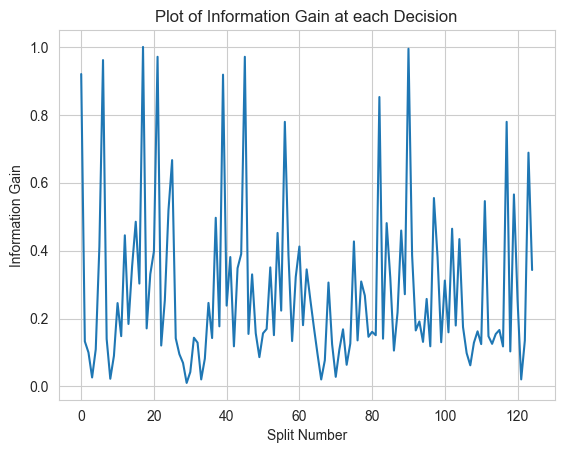

In [18]:
#to plot information gain at each decision step
best_model.plot_information_gain()

### Part 2

**NLP - Word2Vec Model**

In this part, we will learn on how neural networks work on language data. We would be implementing a simple *Continuous bag-of-words (CBOW)* model. (You can read more at https://arxiv.org/abs/1301.3781v3)

**You can use any deep learning library (for example, pytorch or tensorflow) for this part.**

- Create a custom dataloader for Continuous bag-of-words (CBOW) model. This would take the whole text as input and generate samples to train the model. CBOW usualy takes 'n' words before and after a target word and tries to predict the target word. We will use n=2, so the output of the dataloader would be (B,4), (B,1) for X and y respectively (Where B is batch-size).

- Creata a Neural Network with folowing specificaitons 
    - Embedding layer of size 16
    - 2 x Linear layer of size 32
    - ReLU Activation for hidden layer

Train the model for 50 epochs with cross-entropy loss and visualize the final embeddings to understand similarity between the learned word embeddings.

In [12]:
### Write your code here

## Continuous Bag of Word Model
class CBOW(nn.Module):
    def __init__(self, vocab_size, embed_dim, lin_layer_size):
        super(CBOW, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embed_dim) #embedding layer
        self.linear = nn.Linear(embed_dim, lin_layer_size) #linear layer
        self.relu = nn.ReLU()
        self.out = nn.Linear(lin_layer_size, vocab_size) #output layer
        
    def forward(self, x):
        embed = self.embeddings(x).mean(1) #take the avergae of all the embeddings in context of a word
        return self.out(self.relu(self.linear(embed)))
    
#for preprocessing the text, tokenizing it
class PreprocessText:
    def __init__ (self, corpus):
        nlp = spacy.load("en_core_web_sm")
        self.tokenized_text = [token.text for token in nlp(corpus)]
        self.vocab = set(self.tokenized_text)
        self.vocab_size = len(self.vocab)
        self.idx_to_word= {i:w for i,w in enumerate(self.vocab)}
        self.word_to_idx = {w:i for i,w in enumerate(self.vocab)}
        
    def create_dataset(self,n_context_words):
        self.data = []
        for i in range(n_context_words, len(self.tokenized_text) - n_context_words):
            context = []
            for curr_idx in reversed(range(-n_context_words,n_context_words+1)):
                if curr_idx == 0:
                    continue
                context.append(self.word_to_idx[self.tokenized_text[i-curr_idx]])
            
            context.append(self.word_to_idx[self.tokenized_text[i]])
            self.data.append(context)
        self.targets = torch.tensor(self.data)[:,-1]
        self.data = torch.tensor(self.data)[:,:-1]

In [13]:
#Hyperparameter
NUM_CONTEXT_WORDS = 2
BATCH_SIZE = 64
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #this ensures to train on GPU if avialble
NUM_EPOCHS = 50
EMBED_DIM = 100
LIN_LAYER_SIZE = 128
LR = 0.01
PADDING = ' padding ' * NUM_CONTEXT_WORDS

In [15]:
with open('raw_text.txt', "r", encoding="utf-8") as f:
    raw_text = f.read()
    
raw_text = PADDING + raw_text + PADDING
raw_text = re.sub('\W+',' ', raw_text).strip().lower() #for removing pronunciation 

If the below code gives error try running 'python -m spacy download en' in the terminal

In [17]:
#preprocessing the text corpus
text_corpus = PreprocessText(raw_text)
text_corpus.create_dataset(NUM_CONTEXT_WORDS)

#making the text dataloader
text_dataset = torch.utils.data.TensorDataset(text_corpus.data,text_corpus.targets)
text_dataloader = DataLoader(text_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [18]:
VOCAB_SIZE = text_corpus.vocab_size

## Defining Optimizer and Loss
model = CBOW(VOCAB_SIZE, EMBED_DIM, LIN_LAYER_SIZE).double().to(DEVICE) #make the model, send it to GPU and set double precision to avoid errors
optimizer = Adam(model.parameters(),lr=LR) #the adam optimizer is used to train the network
criterion = nn.CrossEntropyLoss() #BCE loss, when loss is applied, sqrt is taken to make it RMSE

In [19]:
# Trainer for training the text
def text_trainer(model, n_epochs, train_loader, criterion, optimizer):
    
    for epoch in range(1, n_epochs + 1):
        epoch_loss = []
        for data, target in train_loader:
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # record training loss and accuracy
            epoch_loss.append(loss.item())
         
        train_loss = np.mean(epoch_loss)
        epoch_len = len(str(n_epochs))
        print_msg = (f'[{epoch:>{epoch_len}}/{n_epochs:>{epoch_len}}] ' +
                     f'train_loss: {train_loss:.5f}')
        
        print(print_msg+'\n')
        
    return model

In [20]:
trained_model = text_trainer(model, NUM_EPOCHS, text_dataloader, criterion, optimizer)

[ 1/50] train_loss: 4.62755

[ 2/50] train_loss: 3.90265

[ 3/50] train_loss: 3.13108

[ 4/50] train_loss: 2.38011

[ 5/50] train_loss: 1.58241

[ 6/50] train_loss: 0.91031

[ 7/50] train_loss: 0.47341

[ 8/50] train_loss: 0.23043

[ 9/50] train_loss: 0.10174

[10/50] train_loss: 0.04564

[11/50] train_loss: 0.02439

[12/50] train_loss: 0.01400

[13/50] train_loss: 0.00840

[14/50] train_loss: 0.00550

[15/50] train_loss: 0.00395

[16/50] train_loss: 0.00303

[17/50] train_loss: 0.00245

[18/50] train_loss: 0.00205

[19/50] train_loss: 0.00176

[20/50] train_loss: 0.00154

[21/50] train_loss: 0.00138

[22/50] train_loss: 0.00125

[23/50] train_loss: 0.00116

[24/50] train_loss: 0.00108

[25/50] train_loss: 0.00102

[26/50] train_loss: 0.00097

[27/50] train_loss: 0.00093

[28/50] train_loss: 0.00089

[29/50] train_loss: 0.00086

[30/50] train_loss: 0.00083

[31/50] train_loss: 0.00081

[32/50] train_loss: 0.00079

[33/50] train_loss: 0.00077

[34/50] train_loss: 0.00075

[35/50] train_

In [21]:
#create a summary writer
writer = SummaryWriter('runs/text/')
writer.add_embedding(trained_model.embeddings.weight.data, metadata = list(text_corpus.vocab), tag='embeddings')
writer.close()

Go in the projector tab of the tensorboard to see the embeddings drawn

![Alt text](embeds.png)